In [1]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import sys
from random import randint

# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = torch.device("cuda")

In [2]:
# Dataloaders
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size)

In [3]:
# Models
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

""" model_regularized_l1 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth")) """

model = model.eval()
""" model_regularized_l1 = model_regularized_l1.eval()
model_regularized_l2 = model_regularized_l2.eval() """

In [4]:
# Concating images
all_images = []
all_masks = []
all_skeletons = []

# Iterate through the entire train_loader
for batch in train_loader:
    images, masks, skeletons = batch
    images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

    all_images.extend(images)
    all_masks.extend(masks)
    all_skeletons.extend(skeletons)
    
for batch in test_loader:
    images, masks, skeletons = batch
    images, masks, skeletons = images.to(device), masks.to(device), skeletons.to(device)

    all_images.extend(images)
    all_masks.extend(masks)
    all_skeletons.extend(skeletons)

In [5]:
# Auxiliary functions
def positive_score(out, target = 1):
  search_domain = out[0, :, :]
  
  for i in range(randint(0, search_domain.shape[0] - 50), search_domain.shape[0]):
        for j in range(randint(0, search_domain.shape[0] - 50), search_domain.shape[1]):
            if search_domain[i, j] > 0:
                return (i, j)
  return None

def compute_softmax_gradient(model, image, skeleton, coordinates_array):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Apply softmax to the output to get class probabilities
    probabilities = F.softmax(out, dim=1)

    # Get the score at the specified coordinates_array for class 1
    while True:
        result = positive_score(skeleton, 1)
        if result is not None:
            x, y = result
            if (x, y) not in coordinates_array:
                coordinates_array.append((x, y))
                break  # Exit the loop if a valid coordinate is found and added
        else:
            # Handle the case when no positive score is found
            # For example, break the loop, or choose a default coordinate, etc.
            break


    coordinates_array.append((x, y))
    score = probabilities[0, 1, x, y]  # Probability of class 1 at (x, y)

    # Compute gradients
    score.backward()

    # Return the gradient
    return image.grad


In [6]:
# Computing grads
coordinates = []
gradients = []
probabilities = []

# Iterate over all images and their corresponding skeletons
for i, (img, skeleton) in enumerate(zip(all_images, all_skeletons)):
    for j in range(10):
        # Compute the gradient at the specified coordinates
        gradient = compute_softmax_gradient(model, img, skeleton, coordinates)
        gradients.append(gradient.detach().cpu().numpy())
        
        coord_index = i * 10 + j
        coord = coordinates[coord_index]
        

        output = model(img.unsqueeze(0))  
        softmax_probs = F.softmax(output, dim=1)
        
        class_one_probs = softmax_probs[0, 1, coord[0], coord[1]].detach().cpu().numpy()
        probabilities.append(class_one_probs)
        if coord_index % 100 == 0:
            print(f'Prob and Grads {coord_index} generate')

Prob and Grads 0 generate
Prob and Grads 100 generate
Prob and Grads 200 generate
Prob and Grads 300 generate
Prob and Grads 400 generate
Prob and Grads 500 generate
Prob and Grads 600 generate
Prob and Grads 700 generate
Prob and Grads 800 generate
Prob and Grads 900 generate


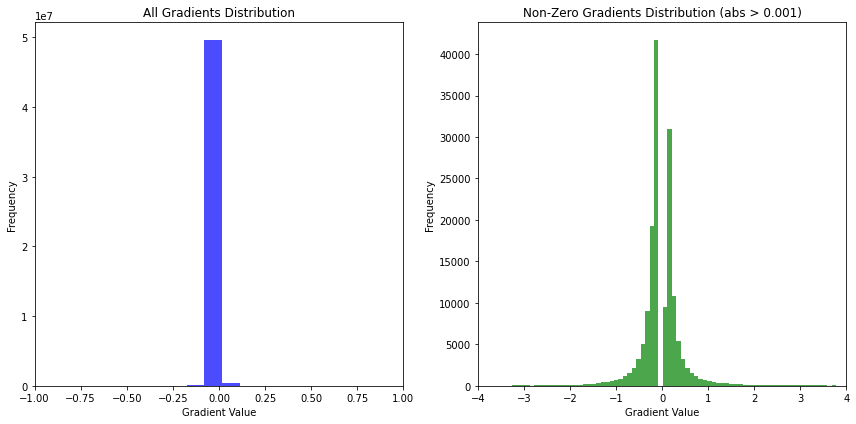

In [7]:
all_gradients = np.concatenate([grad.flatten() for grad in gradients])

# Plot histogram with 300 bins for all gradients
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(all_gradients, bins=300, color='blue', alpha=0.7)
plt.xlim((-1, 1))
plt.title('All Gradients Distribution')
plt.xlabel('Gradient Value')
plt.ylabel('Frequency')

# Filter gradients with absolute value above the threshold (0.001)
threshold = 0.1
non_zero_gradients = all_gradients[np.abs(all_gradients) > threshold]

# Plot histogram with 300 bins for non-zero gradients
plt.subplot(1, 2, 2)
plt.hist(non_zero_gradients, bins=300, color='green', alpha=0.7)
plt.xlim((-4, 4))
plt.title('Non-Zero Gradients Distribution (abs > 0.001)')
plt.xlabel('Gradient Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

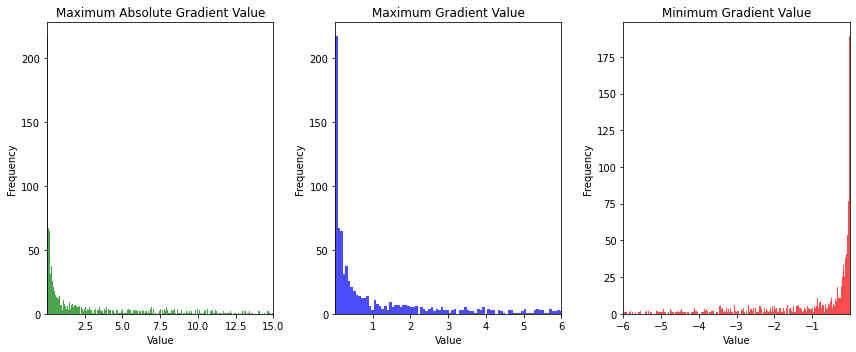

In [8]:
max_abs_values = []  # Store maximum absolute values of gradients
min_values = []      # Store minimum values of gradients
max_values = []

for grad in gradients:
    grad_flat = grad.flatten()
    max_abs_values.append(np.max(np.abs(grad_flat)))
    min_values.append(np.min(grad_flat))
    max_values.append(np.max(grad_flat))

# Plot histogram for maximum absolute values
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.hist(max_abs_values, bins=300, color='green', alpha=0.7)
plt.xlim((0.01, 15))
plt.title('Maximum Absolute Gradient Value')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot histogram for maximum values
plt.subplot(1, 3, 2)
plt.hist(max_values, bins=300, color='blue', alpha=0.7)
plt.xlim((0.01, 6))
plt.title('Maximum Gradient Value')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot histogram for minimum values
plt.subplot(1, 3, 3)
plt.hist(min_values, bins=300, color='red', alpha=0.7)
plt.xlim((-6, -0.01))
plt.title('Minimum Gradient Value')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

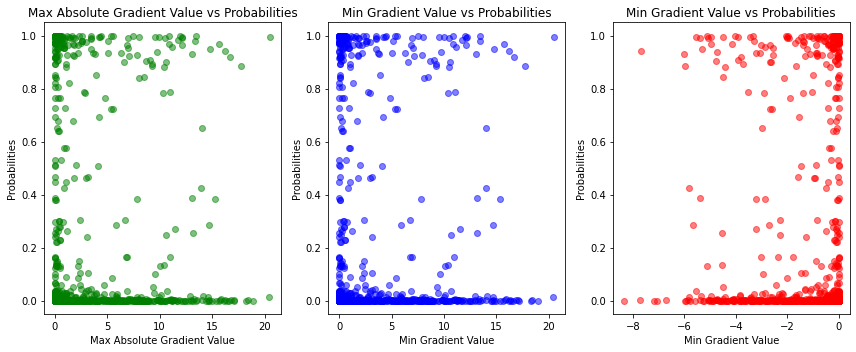

In [9]:
# Create a scatter plot for max_abs_values vs probabilities
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(max_abs_values, probabilities, c='green', alpha=0.5)
plt.title('Max Absolute Gradient Value vs Probabilities')
plt.xlabel('Max Absolute Gradient Value')
plt.ylabel('Probabilities')

# Create a scatter plot for max_values vs probabilities
plt.subplot(1, 3, 2)
plt.scatter(max_values, probabilities, c='blue', alpha=0.5)
plt.title('Min Gradient Value vs Probabilities')
plt.xlabel('Min Gradient Value')
plt.ylabel('Probabilities')

# Create a scatter plot for min_values vs probabilities
plt.subplot(1, 3, 3)
plt.scatter(min_values, probabilities, c='red', alpha=0.5)
plt.title('Min Gradient Value vs Probabilities')
plt.xlabel('Min Gradient Value')
plt.ylabel('Probabilities')

plt.tight_layout()
plt.show()

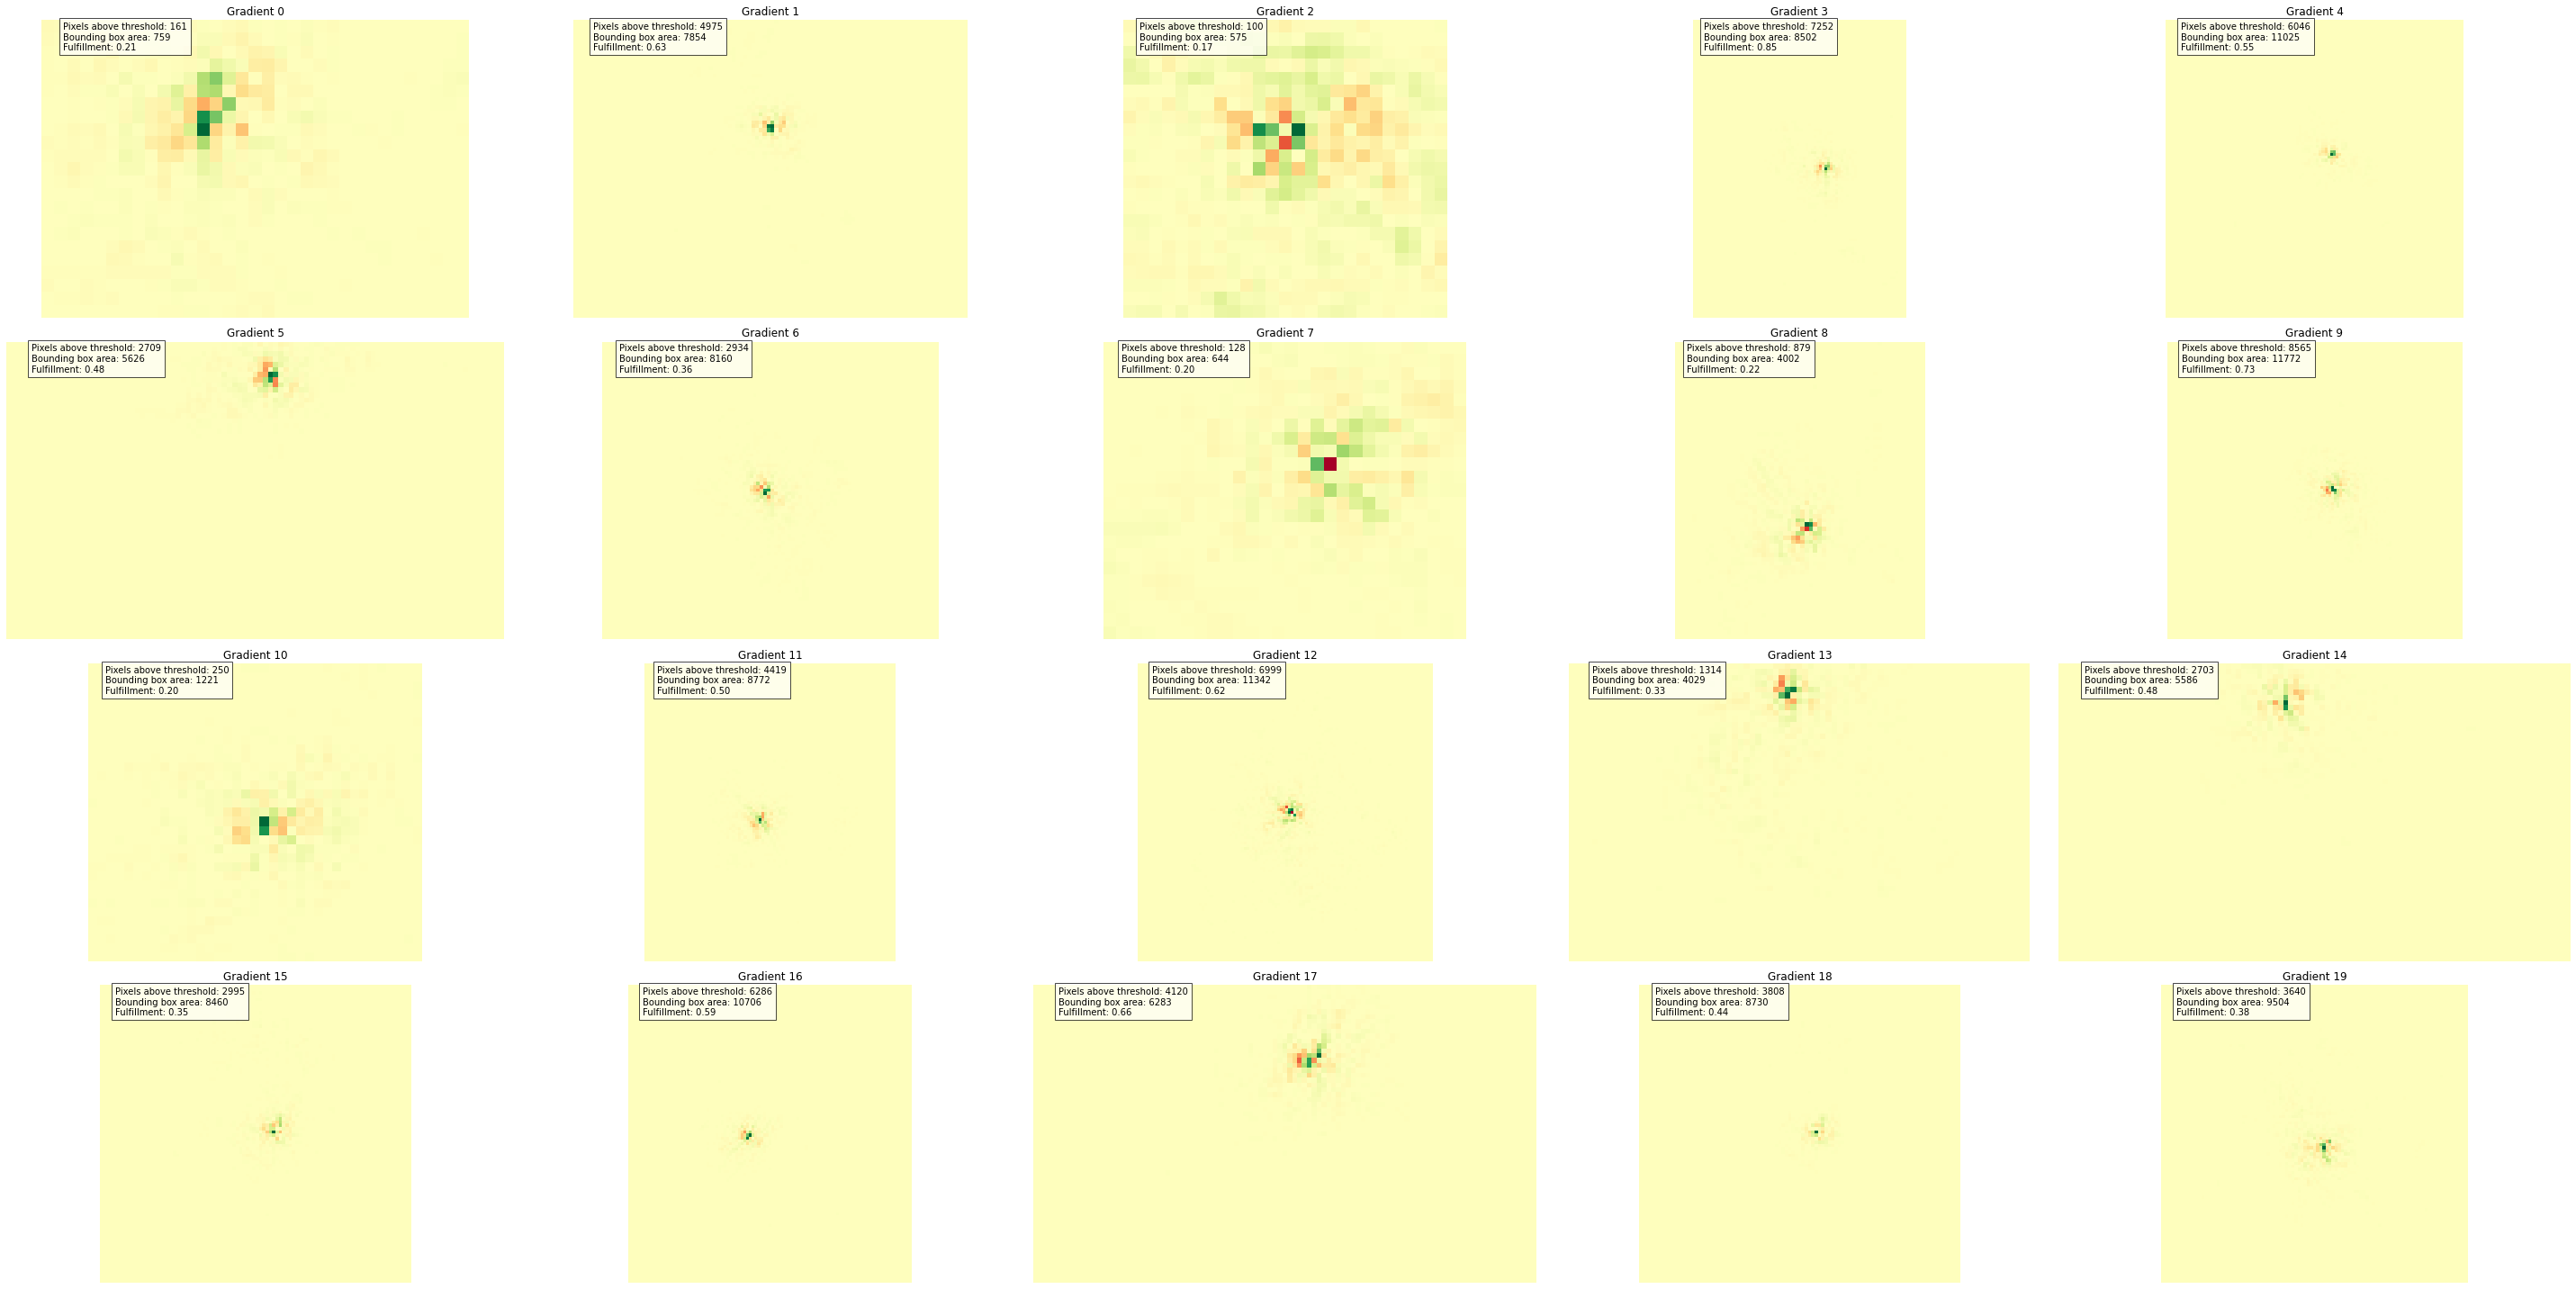

In [11]:
# Define the number of gradients to analyze and the number of rows and columns for subplots
num_gradients_to_analyze = 20
num_rows = num_gradients_to_analyze // 5 + (num_gradients_to_analyze % 5 > 0)
num_cols = min(num_gradients_to_analyze, 5)

# Threshold for gradients
threshold = 0.001

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, 
                        figsize=(num_gradients_to_analyze * 2, num_gradients_to_analyze))

for i in range(num_gradients_to_analyze):
    # Analyze the i-th gradient
    gradient = gradients[i].squeeze()
    
    # Create a mask where gradient values are above the threshold
    mask = np.abs(gradient) > threshold
    
    # Find the bounds of the relevant region
    non_zero_coords = np.nonzero(mask)
    
    # Getting coordinates
    y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
    x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
    
    # Calculate the number of pixels above the threshold
    num_pixels_above_threshold = np.sum(mask)
    
    # Calculate the area of the bounding box
    bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
    
    # Calculate the proportion of the bounding box area that is above the threshold
    fulfillment = num_pixels_above_threshold / bounding_box_area
    
    # Plot the bounding box as a subplot
    row_index, col_index = i // 5, i % 5
    axs[row_index, col_index].imshow(
        gradient[y_min:y_max+1, x_min:x_max+1],
        cmap='RdYlGn',
        vmin=-np.abs(gradient).max(),
        vmax=np.abs(gradient).max(),
        interpolation='nearest'
    )
    axs[row_index, col_index].set_title(f'Gradient {i}')
    axs[row_index, col_index].axis('off')
    
    # Add legend with print information
    axs[row_index, col_index].text(
        0.05, 0.9,
        f"Pixels above threshold: {num_pixels_above_threshold}\nBounding box area: {bounding_box_area}\nFulfillment: {fulfillment:.2f}",
        transform=axs[row_index, col_index].transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7)
    )

plt.tight_layout()
plt.show()